In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ssfm_functions import wavelengthToFreq, freqToWavelength, wavelengthBWtoFreqBW, freqBWtoWavelengthBW, getGammaFromFiberParams
from scipy.constants import pi, c





# Define Raman Gain function

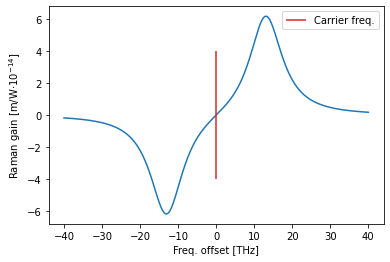

In [2]:

def ramanGainFunction(freq_Hz):
    #Source : https://github.com/omelchert/GNLStools/blob/main/src/GNLStools.py
    tau1=12.2*1e-15
    tau2=30.0*1e-15
    a=4.5*1e-14
    return a*np.imag((tau1**2+tau2**2)/(tau1**2*(1-1j*freq_Hz*2*pi*tau2)**2+tau2**2))

fplot=np.linspace(-40e12,40e12,1000)



gR = ramanGainFunction(fplot)

plt.figure()
plt.plot(fplot/1e12,gR/1e-14)
plt.vlines(x=0,ymin=-4,ymax=4,label="Carrier freq.",color='C3')
plt.xlabel('Freq. offset [THz]')
plt.ylabel('Raman gain [m/W$\cdot10^{-14}$]')
plt.legend()
plt.show()

260
193414489032258.06


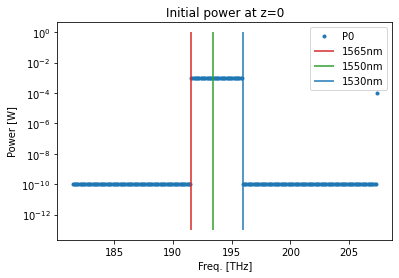

In [3]:
pumpWavelength = 1445e-9 #laser wl in m  
pumpFreq = wavelengthToFreq(pumpWavelength)
channelSpacing_Hz = 100e9
freqList = np.arange(pumpFreq-26e12,pumpFreq,channelSpacing_Hz)
wavelengthList = freqToWavelength(freqList)

print(len(freqList))

f_red_C_band = wavelengthToFreq(1565e-9)
f_blue_C_band = wavelengthToFreq(1530e-9)
f_1550nm =  wavelengthToFreq(1550e-9)
print(f_1550nm)

P_pump = 1e-4 #Power in W at z=0. Note that the pump is launched from the fiber end towards z=0!

P_floor = 1e-10    #Noise floor
P_channels = 1e-3  #Power of channels at z=0

idx_C_band = (f_red_C_band<freqList)*(freqList<f_blue_C_band)

P0list=np.ones_like(freqList)*P_floor

P0list[idx_C_band] = P_channels
P0list[-1]=P_pump


plt.figure()
plt.title('Initial power at z=0')
plt.plot(freqList/1e12,P0list,'.',color='C0',label='P0')
plt.vlines(x=f_red_C_band/1e12,ymin=P_floor*1e-3,ymax=P_channels*1e3,color='C3',label='1565nm')
plt.vlines(x=f_1550nm/1e12    ,ymin=P_floor*1e-3,ymax=P_channels*1e3,color='C2',label='1550nm')
plt.vlines(x=f_blue_C_band/1e12    ,ymin=P_floor*1e-3,ymax=P_channels*1e3,color='C0',label='1530nm')



plt.yscale('log')
plt.xlabel('Freq. [THz]')
plt.ylabel('Power [W]')
plt.legend()
plt.show()









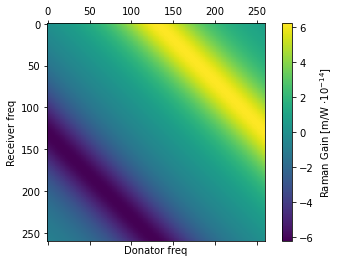

In [12]:
#Fill out Raman Gain matrix
N=len(freqList)
gR_matrix = np.zeros( (N,N)  )

for i in range(N):
   gR_matrix[i,:]=ramanGainFunction(freqList-freqList[i] )  
        
#Plot Raman gain matrix

fig,ax=plt.subplots()
surf=ax.matshow(gR_matrix/1e-14)
ax.set_xlabel('Donator freq')
ax.set_ylabel('Receiver freq')
cbar=fig.colorbar(surf, ax=ax)
cbar.set_label('Raman Gain [m/W $\cdot10^{-14}$]')
plt.show()        




In [13]:
from scipy.integrate import solve_ivp

def dIdz(z,I):
    signlist=np.ones_like(I)*1.0
    signlist[-1]=-2
    attenuation_at_1550nm =  0.2e-3/4.34
    return (np.dot(gR_matrix,I)-attenuation_at_1550nm*signlist)*I

def prob_no_gain(z,I):
    signlist=np.ones_like(I)*1.0
    signlist[-1]=-2
    attenuation_at_1550nm =  0.2e-3/4.34
    return I*np.exp(-attenuation_at_1550nm*signlist*z)


#Calculate intensity
d_SMF = 9e-6
A_SMF = pi*d_SMF**2/4
I0_SMF = P0list/A_SMF

z0=0.0
zmax_SMF = 100e3 #m
z_steps_SMF = np.linspace(z0,zmax_SMF,100)

sol_SMF=solve_ivp(dIdz,
                  (z0,zmax_SMF),
                  I0_SMF,
                  t_eval=z_steps_SMF,
                  method='RK45',
                  vectorized=True) 


sol_no_gain = prob_no_gain(zmax_SMF,I0_SMF)

sol_no_gain_119 = I0_SMF[119]*np.exp(-0.2e-3/4.34*z_steps_SMF)

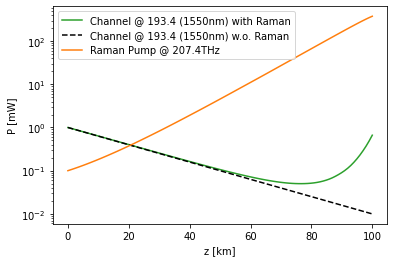

In [14]:
plt.figure()
plt.plot(sol_SMF.t/1e3,sol_SMF.y[119,:]*A_SMF/1e-3,color="C2",label=f'Channel @ {freqList[119]/1e12:.4} (1550nm) with Raman')
plt.plot(sol_SMF.t/1e3,sol_no_gain_119*A_SMF/1e-3,'k--',label=f'Channel @ {freqList[119]/1e12:.4} (1550nm) w.o. Raman')
plt.plot(sol_SMF.t/1e3,sol_SMF.y[-1,:]*A_SMF/1e-3,color="C1",label=f'Raman Pump @ {freqList[-1]/1e12:.4}THz')
plt.xlabel('z [km]')
plt.ylabel('P [mW]')
plt.yscale('log')
plt.legend()
plt.show()

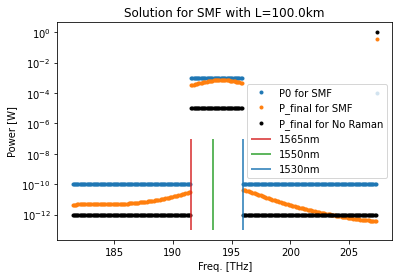

In [8]:
plt.figure()
plt.title(f"Solution for SMF with L={zmax_SMF/1e3}km")
plt.plot(freqList/1e12,sol_SMF.y[:,0]*A_SMF,'.',color='C0',label='P0 for SMF')
plt.plot(freqList/1e12,sol_SMF.y[:,-1]*A_SMF,'.',color='C1',label='P_final for SMF')
plt.plot(freqList/1e12,sol_no_gain*A_SMF,'.',color='k',label='P_final for No Raman')
plt.vlines(x=f_red_C_band/1e12,ymin=P_floor*1e-3,ymax=P_floor*1e3,color='C3',label='1565nm')
plt.vlines(x=f_1550nm/1e12    ,ymin=P_floor*1e-3,ymax=P_floor*1e3,color='C2',label='1550nm')
plt.vlines(x=f_blue_C_band/1e12    ,ymin=P_floor*1e-3,ymax=P_floor*1e3,color='C0',label='1530nm')
plt.legend()
plt.xlabel('Freq. [THz]')
plt.ylabel('Power [W]')
plt.yscale('log')
plt.show()

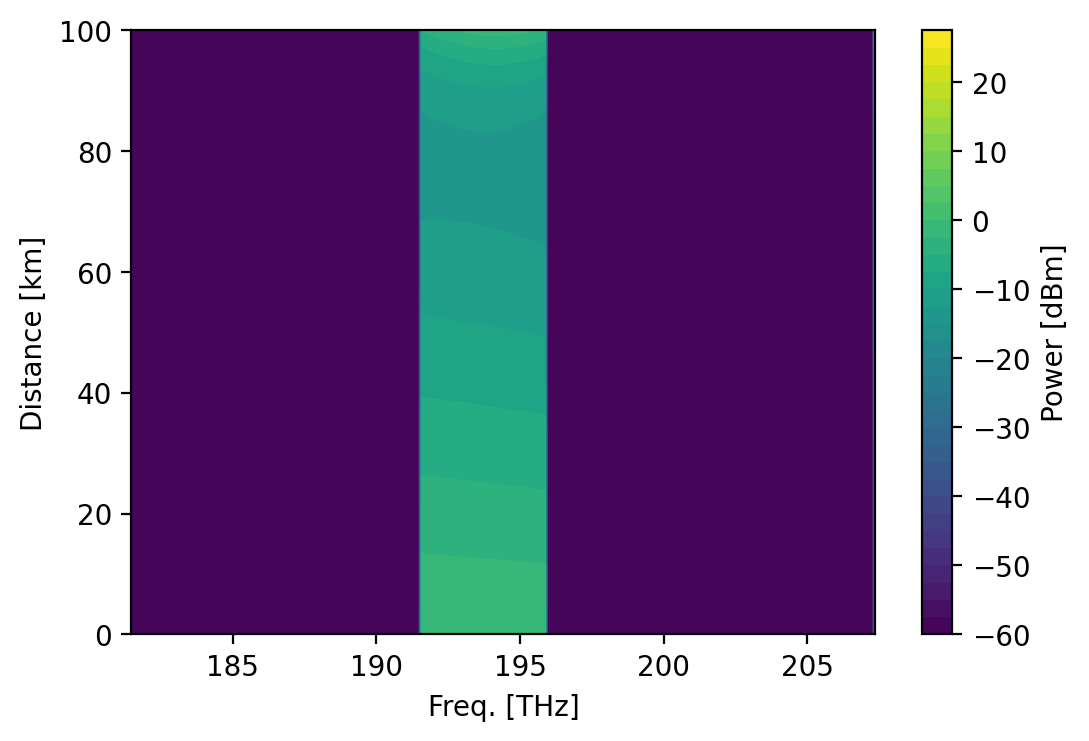

In [20]:
#Make surface plot of solution
fig, ax = plt.subplots(dpi=200)
F, Z = np.meshgrid(freqList/1e12,sol_SMF.t)
P_SMF = 10*np.log10(sol_SMF.y.T*A_SMF/1e-3)
P_SMF[ P_SMF<-60 ] = -60
surf=ax.contourf(F, Z/1e3, P_SMF,levels=40)
ax.set_xlabel('Freq. [THz]')
ax.set_ylabel('Distance [km]')
cbar=fig.colorbar(surf, ax=ax) 
cbar.set_label('Power [dBm]')
plt.show()

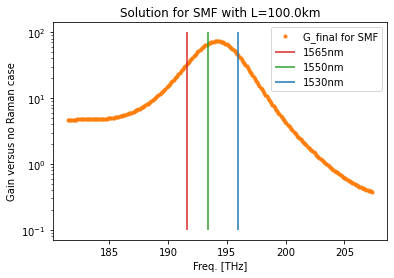

In [11]:
plt.figure()
plt.title(f"Solution for SMF with L={zmax_SMF/1e3}km")
plt.plot(freqList/1e12,sol_SMF.y[:,-1]/sol_no_gain,'.',color='C1',label='G_final for SMF')
plt.vlines(x=f_red_C_band/1e12,ymin=1e-1,ymax=1e2,color='C3',label='1565nm')
plt.vlines(x=f_1550nm/1e12    ,ymin=1e-1,ymax=1e2,color='C2',label='1550nm')
plt.vlines(x=f_blue_C_band/1e12    ,ymin=1e-1,ymax=1e2,color='C0',label='1530nm')
plt.legend()
plt.xlabel('Freq. [THz]')
plt.ylabel('Gain versus no Raman case')
plt.yscale('log')
#plt.ylim(1e-14,1e14)
plt.show()